Classify handwritten digits with k-NN
---

Exercise - Load data set
--

> **Exercise**: Load the data from the `mnist-6k.npz` file into X/y arrays. The data type of the input matrix `X` should be `float64`. Split it into train (5,000 images) and test (1,000) sets using the `train_test_split()` function. Set the `random_state` to zero. 

In [1]:
import numpy as np

with np.load('mnist-6k.npz', allow_pickle=False) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

['data', 'labels']


In [15]:


with np.load('mnist-6k.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    X = npz_file['data']
    y = npz_file['labels']


print('X:', X)
print('y:', y)

X[1].shape

X: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y: [5 0 4 ... 8 6 9]


(784,)

In [16]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)


# Split data into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=5000, test_size=1000, random_state=0)

Exercise: Data exploration
---

> **Exercise**: What are the different categories? What is the proportion of images in each one?

In [17]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
np.bincount(y)

array([592, 671, 581, 608, 623, 514, 608, 651, 551, 601], dtype=int64)

In [19]:
import pandas as pd

# The categories correspond to digits from 0 and 9
# There is approximately the same proportion of images (~10%) for each class
pd.value_counts(y, normalize=True)

1    0.111833
7    0.108500
4    0.103833
3    0.101333
6    0.101333
9    0.100167
0    0.098667
2    0.096833
8    0.091833
5    0.085667
dtype: float64

> **Exercise**: Plot some images with their labels from the X/y arrays.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt


In [25]:
# Extract the third image
flat_img = X[3] # third row
# Print shape
print('shape:', X[3].shape)


# Reshape the image
img = flat_img.reshape(28, 28)


# Print shape
print('shape:', img.shape)


shape: (784,)
shape: (28, 28)


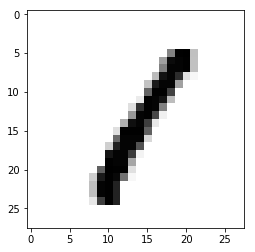

In [26]:

# Plot the image
plt.imshow(img, cmap=plt.cm.gray_r)
plt.show()

Exercise: Set a baseline
---

> **Exercise**: Create a baseline model using the `DummyClassifier` object from Scikit-learn and evaluate its performance on the test set.

In [27]:
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Fit it to the train data
dummy.fit(X_tr, y_tr)

# Compute accuracy on the test set
accuracy = dummy.score(X_te, y_te)
print('Baseline accuracy: {:.3f}'.format(accuracy))

Baseline accuracy: 0.105


Exercise: Create k-NN classifier
---

> **Exercise**: Build a k-NN classifier using a `Pipeline` object (set k to 5). Try with and without standardization.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=5, # Set k to 5
    # Use the simple 'brute' strategy to find nearest neighbors.
    # It's faster in this case!
    algorithm='brute'
)

# Create the pipeline and fit it to training data
knn_pipe = Pipeline([
    #('scaler', StandardScaler()), # With standardization
    ('scaler', None), # Better performance without standardization!
    ('knn', knn)
])
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)

# Print accuracy
print('k-nearest neighbors (k=5) accuracy: {:.3f}'.format(accuracy))

k-nearest neighbors (k=5) accuracy: 0.941


Exercise: Tune k using grid search
---

> **Exercise**: Tune k using grid search. Plot the test accuracy.

**Hint**: You don't have to compute the train accuracy which is computationally expensive due to the size of the train set.

In [42]:
accuracy_gs = []
for k in range(1,20):
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)
    accuracy_gs.append({
            'k': k,
            'test_accuracy': knn_pipe.score(X_te, y_te)
        })
    
# Convert results to DataFrame
gs_results = pd.DataFrame(accuracy_gs)
gs_results

k  test_accuracy
0    1          0.952
1    2          0.943
2    3          0.951
3    4          0.949
4    5          0.941
5    6          0.941
6    7          0.939
7    8          0.941
8    9          0.944
9   10          0.941
10  11          0.943
11  12          0.941
12  13          0.941
13  14          0.937
14  15          0.936
15  16          0.930
16  17          0.930
17  18          0.931
18  19          0.929

In [45]:
# Group results by alpha value
grouped = gs_results.groupby('k')

# Compute train/test mean scores with std
mean_te = grouped.test_accuracy.mean()
std_te = grouped.test_accuracy.std()

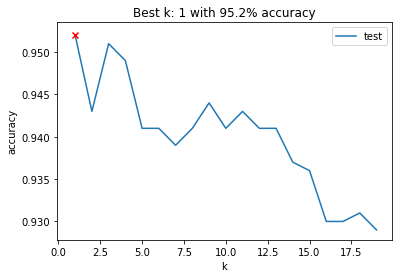

In [48]:
# Plot mean scores
plt.plot(range(1,20), mean_te, label='test')

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker='x', c='red', zorder=10)

# Quantify variance with ±std curves

plt.fill_between(range(1,20), mean_te-std_te, mean_te+std_te, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*mean_te[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()